In [1]:
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from time import time
import datetime
from random_erasing import random_erasing_img
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
train_path = '/content/train'
valid_path = '/content/valid'
test_path = '/content/test'
img_size =  (224,224,3)
BATCH_SIZES = 64
EPOCHS = 100

In [4]:
erase_datagen = ImageDataGenerator(rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   channel_shift_range = 10,
                                   horizontal_flip = True,
                                   preprocessing_function = random_erasing_img(),
                                   fill_mode = 'nearest')

datagen = ImageDataGenerator(rotation_range = 40,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             channel_shift_range = 10,
                             horizontal_flip = True,
                             fill_mode = 'nearest')

In [5]:
train_batches = erase_datagen.flow_from_directory(directory = train_path, 
                                                  color_mode = "rgb",
                                                  target_size = (224,224),
                                                  interpolation = 'bicubic',
                                                  class_mode = "sparse",
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZES)

valid_batches = datagen.flow_from_directory(directory = valid_path,
                                            color_mode = "rgb",
                                            target_size = (224,224),
                                            interpolation = 'bicubic',
                                            class_mode = "sparse",
                                            shuffle = False,
                                            batch_size = BATCH_SIZES)

test_batches = datagen.flow_from_directory(directory = test_path,
                                           color_mode = "rgb",
                                           target_size = (224,224),
                                           interpolation = 'bicubic',
                                           class_mode = "sparse",
                                           shuffle = False,
                                           batch_size = BATCH_SIZES)

Found 17500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.
Found 3600 images belonging to 2 classes.


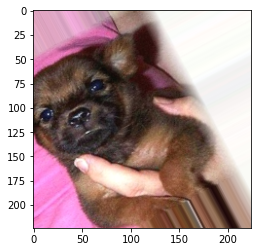

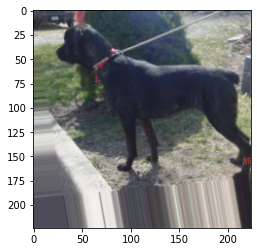

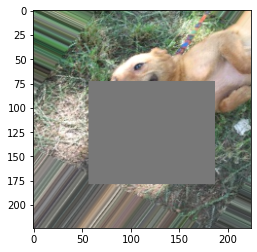

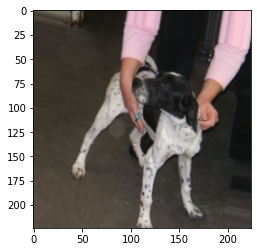

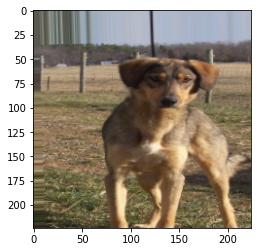

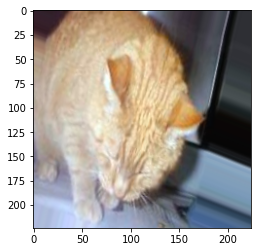

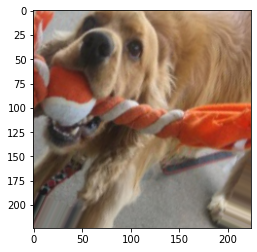

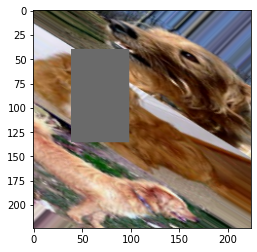

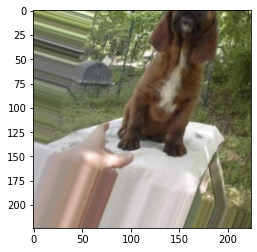

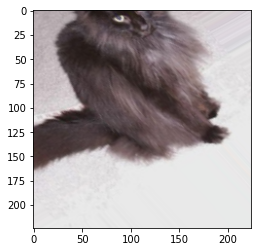

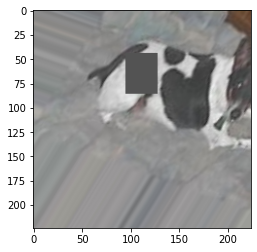

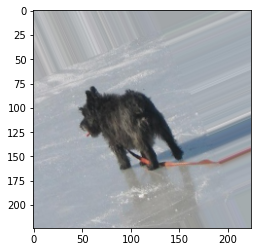

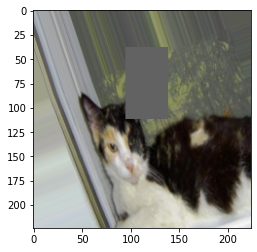

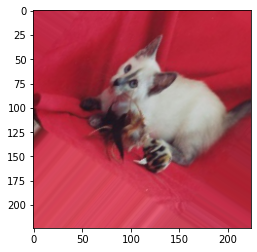

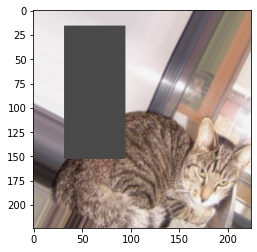

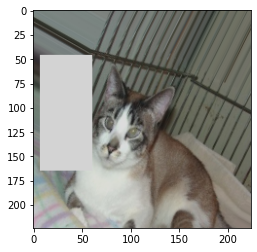

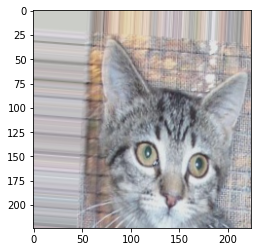

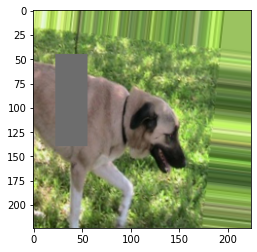

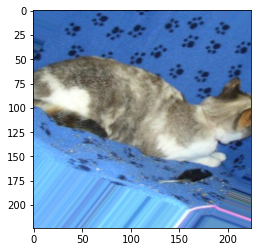

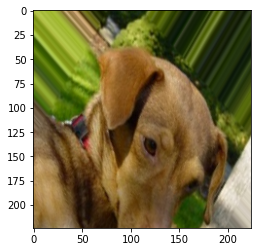

In [6]:
#trainnning data
for i in range(20):
    plt.imshow(train_batches[0][0][i].astype('uint8'))
    plt.show()

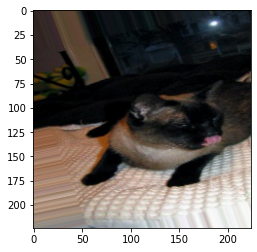

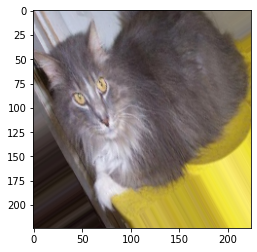

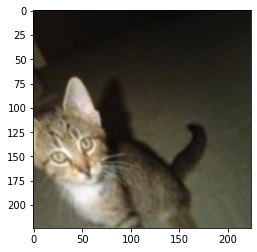

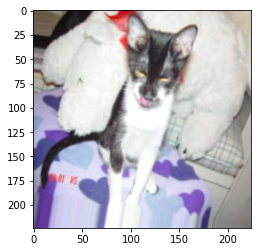

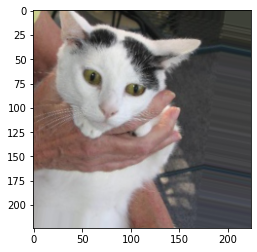

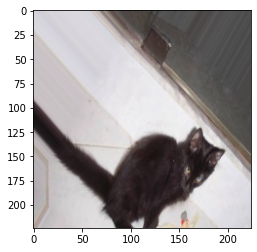

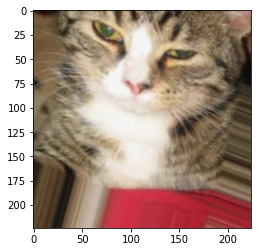

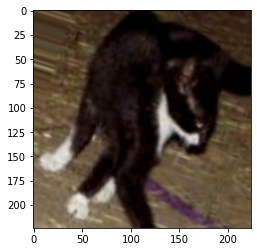

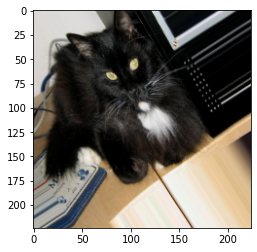

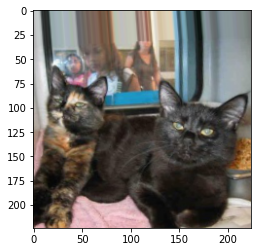

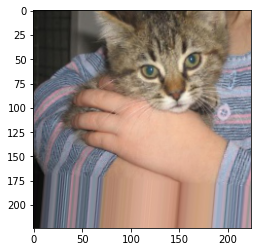

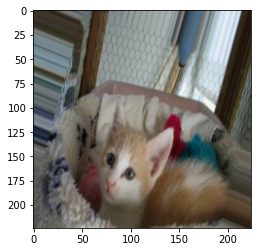

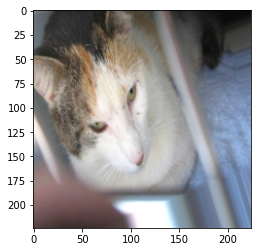

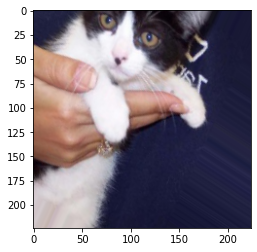

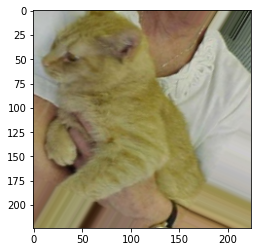

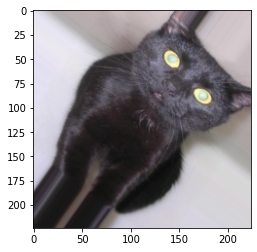

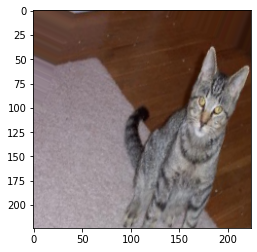

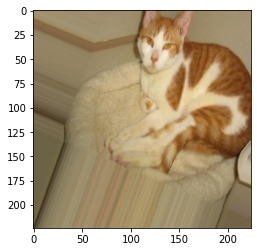

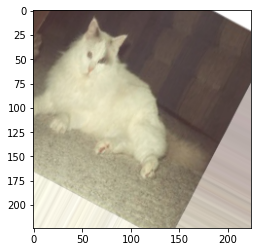

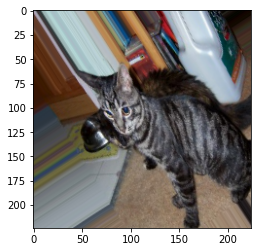

In [7]:
for i in range(20):
    plt.imshow(valid_batches[0][0][i].astype('uint8'))
    plt.show()

# Fine Tune ResNet50 with low lr

In [8]:
# construct Model
res50 = ResNet50(input_shape = img_size,
                 weights = "imagenet",
                 include_top = False)
x = GlobalAveragePooling2D()(res50.output)
output = Dense(2, activation = 'softmax')(x)
model = Model(inputs = res50.input, outputs = output, name = "resnet50_transfer")

# freeze some layers
for ind,layer in enumerate(model.layers):
    if layer.name == "conv2_block3_3_conv":
        freeze_layer = ind
for layer in model.layers[:freeze_layer]:
    layer.trainable = False
for layer in model.layers[freeze_layer:]:
    layer.trainable = True
model.summary()

Model: "resnet50_transfer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________

In [9]:
callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=6, verbose=1, min_lr = 1e-7)
opt = Adam(learning_rate = 1e-5)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy' , 
              metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")])
t1 = time()
history = model.fit(train_batches,
                    steps_per_epoch = train_batches.samples // BATCH_SIZES,
                    validation_data = valid_batches,
                    validation_steps = valid_batches.samples // BATCH_SIZES,
                    callbacks=[callback, reduce_lr], 
                    epochs= EPOCHS, 
                    shuffle = True)
t2 = time()
model.save_weights('./Fine_tune_resnet_batch' + str(BATCH_SIZES) + '.h5')
print("execution time:",t2-t1)

Epoch 1/100
273/273 [==============================] - 159s 562ms/step - loss: 0.3989 - accuracy: 0.8058 - val_loss: 0.0584 - val_accuracy: 0.9771
Epoch 2/100
273/273 [==============================] - 152s 555ms/step - loss: 0.0952 - accuracy: 0.9623 - val_loss: 0.0537 - val_accuracy: 0.9793
Epoch 3/100
273/273 [==============================] - 151s 554ms/step - loss: 0.0809 - accuracy: 0.9656 - val_loss: 0.0428 - val_accuracy: 0.9844
Epoch 4/100
273/273 [==============================] - 151s 553ms/step - loss: 0.0655 - accuracy: 0.9743 - val_loss: 0.0343 - val_accuracy: 0.9879
Epoch 5/100
273/273 [==============================] - 151s 553ms/step - loss: 0.0656 - accuracy: 0.9763 - val_loss: 0.0471 - val_accuracy: 0.9814
Epoch 6/100
273/273 [==============================] - 151s 551ms/step - loss: 0.0485 - accuracy: 0.9822 - val_loss: 0.0388 - val_accuracy: 0.9846
Epoch 7/100
273/273 [==============================] - 150s 550ms/step - loss: 0.0496 - accuracy: 0.9797 - val_loss: 0

In [10]:
score = model.evaluate(test_batches)
print("Accuracy: ",score[1])

57/57 [==============================] - 26s 448ms/step - loss: 0.0359 - accuracy: 0.9900
Accuracy:  0.9900000095367432


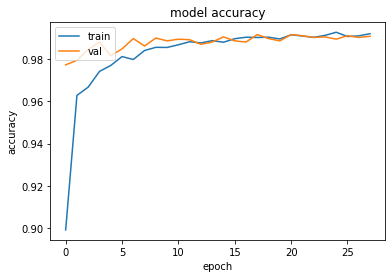

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

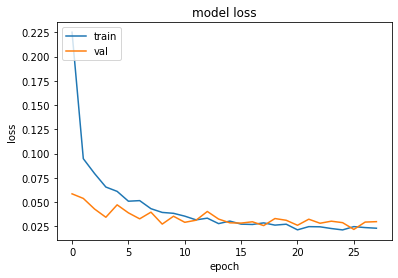

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
from sklearn.metrics import classification_report
test_labels = test_batches.classes 
predictions = model.predict(test_batches, verbose=1)
y_pred = np.argmax(predictions, axis=-1)
print(classification_report(test_labels, y_pred, target_names = test_batches.class_indices))

57/57 [==============================] - 26s 449ms/step
              precision    recall  f1-score   support

         cat       0.99      0.99      0.99      1800
         dog       0.99      0.99      0.99      1800

    accuracy                           0.99      3600
   macro avg       0.99      0.99      0.99      3600
weighted avg       0.99      0.99      0.99      3600

